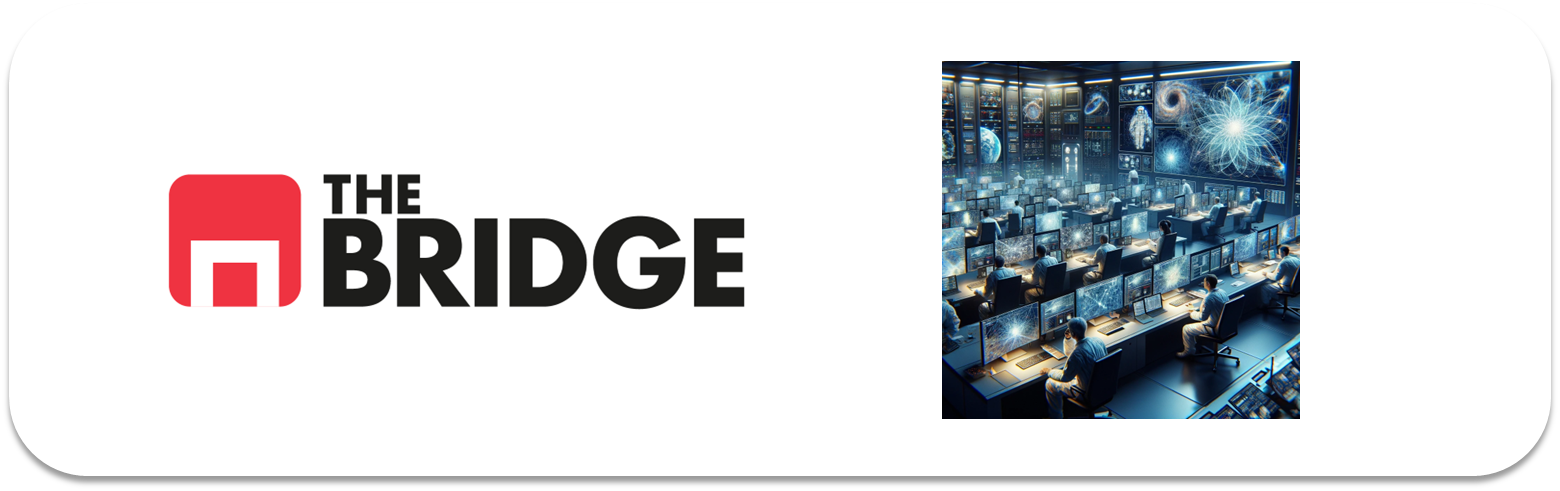

## PRACTICA OBLIGATORIA: **Redes Convolucionales**

* La práctica obligatoria de esta unidad consiste en un ejercicio de construcción de una red convolucional con Keras para la clasificación de imagenes de simpáticos perretes y gatetes. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from skimage.io import imread
from sklearn.utils import shuffle
import seaborn as sns
from sklearn.metrics import confusion_matrix
import keras
import cv2

### Problema de Negocio y dataset

Una conocida empresa de información inmobiliaria utiliza un CAPTCHA visual de perros y gatos para detectar webscrappings intensivos y ataques de denegación de servicio. Últimamente, ha detectado que su sistema está empezando a flojear, es decir que hay muchos sistemas de detección automática de imágenes que son capaces de detectar que es un perro y un gato y salterse el CAPTCHA antirobots. Por eso nos ha pedido que entrenemos un modelo potente de clasificación que emule a estos sistemas con el objetivo de emplear como fotografías para el CAPTCHA aquellas que no sepa detectar este sistema emulador de chicos malos.  

Pues manos a la obra, tenemos que seleccionar en un conjunto de 1000 imágenes aquellas que peor se le daría clasificar a un potencial sistema anti-CAPTCHA.  

Para ello vamos a emplear un conjunto de train de 4000 imágenes de perretes y gatetes que se encuentran distribuidas en "data" en cuatro directorios "github_train_0",  "github_train_1", "githun_train_2" y "github_train_3". Los datos de las imagenes que tenemos que clasificar y luego seleccionar como las más "difíciles" están en "data" en el directorio "github_test".


### Se pide

1. Crear los datasets X,y de train y test, leyendo las imágenes de los directorios correspondientes (tendrás que leer todas las imágenes de los cuatro directorios para train) y a la vez que se leen adpatar su resolución para que todas tengan un tamaño de 32x32. En este caso puedes adaptar las funciones de los ejercicios de la unidad. NOTA: Ten en cuenta que la clase a la que pertenece en la foto está en el nombre del archivo.

2. Crea un modelo DL basado en redes convolucionales con al menos dos juegos Convolucional-Pooling. Sigue todo el proceso de ML (visualización del dataset, MiniEDA, Construcción del modelo)

3. Entrenar el modelo con un callback de Earlystopping con paciencia la que tengas :-). Muestra su historial de entrenamiento.

4. Evalua el modelo, haz un reporte de clasificacion y muestra la matriz de confianza.

5. Es el momento de seleccionar las imagenes: Selecciona el 10% de imágenes mal clasificadas de una y otra clase que tengan el mayor nivel de confianza de que pertenencían a la clase errónea. Es decir las imágenes de perros clasificadas como gatos y con la probabilidad de ser perror más alta.


### Extra (para hacer en clase)

Repite los pasos 3 a 5 utilizando el generador de imágenes sintéticas o Image Augmentation de Keras. 



In [2]:
ROOT_PATH = "./data/"
TRAIN_PATH = ROOT_PATH + "github_train_0/"
TRAIN_PATH1 = ROOT_PATH + "github_train_1/"
TRAIN_PATH2= ROOT_PATH + "github_train_2/"
TRAIN_PATH3 = ROOT_PATH + "github_train_3/"
TEST_PATH = ROOT_PATH + "github_test/"

In [24]:
def read_data(directorio, reshape_dim = (32,32)):
    X = [] 
    y = []
    for file in os.listdir(directorio):
        image = imread('/'.join([directorio, file]))
        image = cv2.resize(image, reshape_dim) # Redimensionamos las imágenes a 32x32

        X.append(image)
        y.append(0 if "dog" in file else 1)

    return np.array(X),np.array(y)

In [25]:
X_train,y_train = read_data(TRAIN_PATH)
X_train1,y_train1 = read_data(TRAIN_PATH1)
X_train2,y_train2 = read_data(TRAIN_PATH2)
X_train3,y_train3 = read_data(TRAIN_PATH3)
X_test,y_test = read_data(TEST_PATH)
# Nota: podríamos dejar la creación de X_test para el final antes de usarlo y así ahorra memoria mientras no tengamos que emplearlo

In [26]:
X_train = np.concatenate((X_train, X_train1, X_train2, X_train3), axis=0)
y_train = np.concatenate((y_train, y_train1, y_train2, y_train3), axis=0)


# Verifica las formas de las matrices combinadas
print("Forma de X_combined_train:", X_train.shape)
print("Forma de y_test:", y_train.shape)

Forma de X_combined_train: (4000, 32, 32, 3)
Forma de y_test: (4000,)


In [27]:
def show_images_batch(paisajes, names = [], n_cols = 5, size_scale = 2):
    n_rows = ((len(paisajes) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1*size_scale))
    for index, paisaje in enumerate(paisajes):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(paisaje, cmap = "Greys")
        plt.axis("off")
        if len(names):
            plt.title(names[index])

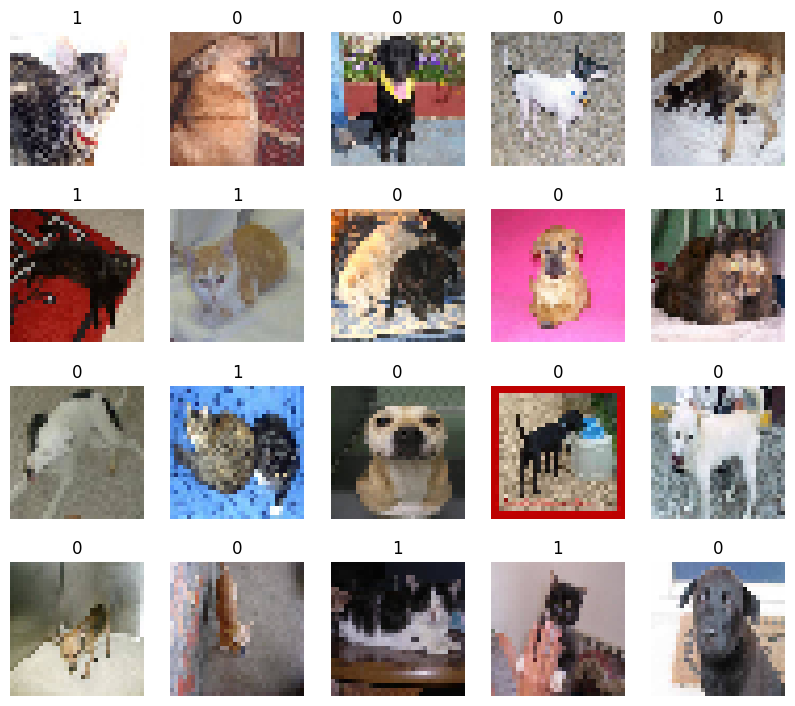

In [28]:
indices = np.random.randint(0,len(X_train),20)
show_images_batch(X_train[indices], names = y_train[indices], n_cols = 5)

In [29]:
targets = pd.Series(y_train)
targets.value_counts(True)

1    0.5
0    0.5
Name: proportion, dtype: float64

In [30]:
X_train = X_train/255
X_test = X_test/255

In [31]:
# Primero definimos las capas de la red, en este caso partimos de 30 filtros de 3x3, seguido de una capa de pooling de 2x2,
# El input shape es el tamaño de las imágenes de entrada, en nuestro caso 32x32x3. 
# El tamaño del kernel es pequeño pero suele ser de este tipo y más con resoluciones tan bajas, el número de filtros está escogido de aquella manera,
# juega con el número de filtros.

capas = [keras.layers.Conv2D(filters = 30, kernel_size = (3, 3),
                            input_shape = (X_train[0].shape), 
                            padding = "same",
                            activation = 'relu'),
         keras.layers.MaxPooling2D(pool_size = (2, 2)),

# Añadimos otra capa de convolución y pooling
         keras.layers.Conv2D(filters = 15, 
                             kernel_size = (3, 3),
                             padding = "same", 
                             activation = 'relu'),
         keras.layers.MaxPooling2D(pool_size = (2, 2)),

# Añadimos una capa de flatten para convertir la salida de la capa de pooling en un vector
         keras.layers.Flatten(),

# Añadimos dos capas densas para la clasificación 
         keras.layers.Dense(units = 150, activation = 'relu'),
         keras.layers.Dense(units = 100, activation = 'relu'),

# Añadimos la capa de salida con 6 neuronas, una por cada clase
         keras.layers.Dense(6, activation = 'softmax')]

# Creamos el modelo
model = keras.Sequential(capas)

In [32]:
X_train.size

12288000

In [33]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')

In [34]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 30)        840       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 30)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 15)        4065      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 8, 8, 15)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 960)               0         
                                                                 
 dense_3 (Dense)             (None, 150)              

In [35]:
mapa = {tipo:indice for indice,tipo in enumerate(targets.unique())} # Rehusando la serie que creamos para ver la distribución del target
mapa

{1: 0, 0: 1}

In [36]:
y_train_num = np.array([mapa[y] for y in y_train])
y_test_num = np.array([mapa[y] for y in y_test])

In [37]:
# Revolvemos los datos para que el modelo no aprenda en orden de las imágenes
X_train, y_train_num = shuffle(X_train, y_train_num)

In [38]:
history = model.fit(X_train,
                    y_train_num,
                    validation_split = 0.2,
                    epochs = 100,
                    batch_size = 32, callbacks= [keras.callbacks.EarlyStopping(patience = 10, restore_best_weights= True)]) # Queremos recuperar los pesos de la mejor de las epocas durante el periodo de patience

Epoch 1/100
100/100 [==============================] - 4s 14ms/step - loss: 0.7268 - accuracy: 0.5494 - val_loss: 0.6738 - val_accuracy: 0.5550
Epoch 2/100
100/100 [==============================] - 1s 11ms/step - loss: 0.6535 - accuracy: 0.6200 - val_loss: 0.6161 - val_accuracy: 0.6600
Epoch 3/100
100/100 [==============================] - 1s 12ms/step - loss: 0.5969 - accuracy: 0.6753 - val_loss: 0.5888 - val_accuracy: 0.6850
Epoch 4/100
100/100 [==============================] - 1s 11ms/step - loss: 0.5689 - accuracy: 0.7013 - val_loss: 0.5901 - val_accuracy: 0.6737
Epoch 5/100
100/100 [==============================] - 1s 11ms/step - loss: 0.5377 - accuracy: 0.7259 - val_loss: 0.5577 - val_accuracy: 0.7125
Epoch 6/100
100/100 [==============================] - 1s 12ms/step - loss: 0.5224 - accuracy: 0.7431 - val_loss: 0.5941 - val_accuracy: 0.6862
Epoch 7/100
100/100 [==============================] - 1s 12ms/step - loss: 0.5137 - accuracy: 0.7372 - val_loss: 0.5585 - val_accuracy:

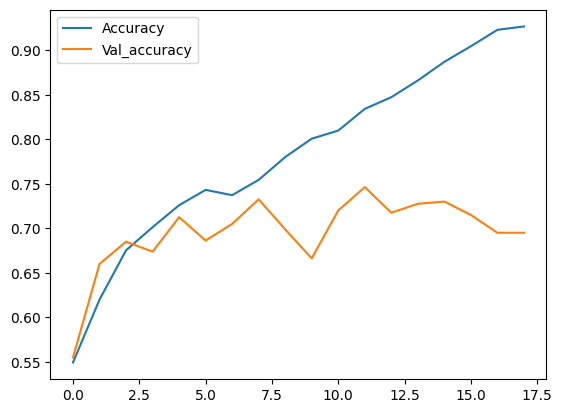

In [39]:
# Representamos el objeto history
history_df = pd.DataFrame(history.history)
plt.plot(history_df['accuracy'], label = 'Accuracy')
plt.plot(history_df['val_accuracy'], label = 'Val_accuracy')

plt.legend();

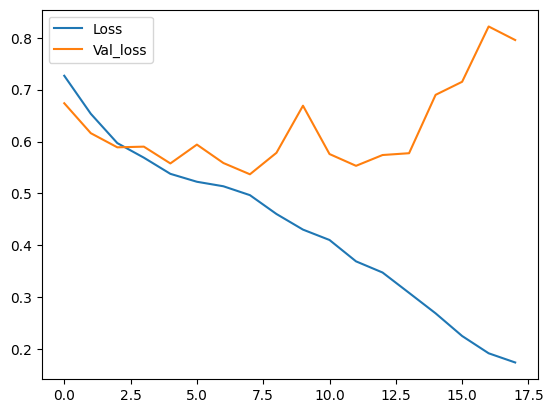

In [40]:
plt.plot(history_df['loss'], label = 'Loss')
plt.plot(history_df['val_loss'], label = 'Val_loss')

plt.legend();

In [41]:
model.evaluate(X_test, y_test_num)

32/32 [==============================] - 0s 6ms/step - loss: 0.5500 - accuracy: 0.7350


[0.5500103831291199, 0.7350000143051147]

In [42]:
y_pred = [ np.argmax(prediction) for prediction in model.predict(X_test)]

32/32 [==============================] - 0s 5ms/step


In [43]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
inverse_map = {valor:clave for clave,valor in mapa.items()}
y_test_labels = [inverse_map[y] for y in y_test_num]
y_pred_labels = [inverse_map[y] for y in y_pred]
print(classification_report(y_test_labels, y_pred_labels))

              precision    recall  f1-score   support

           0       0.73      0.75      0.74       500
           1       0.74      0.72      0.73       500

    accuracy                           0.73      1000
   macro avg       0.74      0.73      0.73      1000
weighted avg       0.74      0.73      0.73      1000



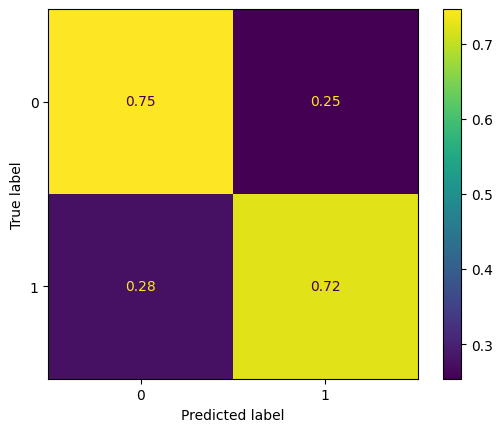

In [44]:
ConfusionMatrixDisplay.from_predictions(y_test_labels, y_pred_labels, normalize="true")

In [45]:
confianza = [prediction.max() for prediction in model.predict(X_test)]

32/32 [==============================] - 0s 5ms/step


In [46]:
pred_df = pd.DataFrame({"True": y_test_labels, "Predicted": y_pred_labels, "Confianza": confianza})

In [47]:
error = pred_df["True"] != pred_df["Predicted"]
errores = pred_df[error].sort_values("Confianza", ascending = False)
errores

,True,Predicted,Confianza
337,1,0,0.996511
680,0,1,0.993883
368,1,0,0.979975
537,0,1,0.976153
834,0,1,0.974064
...,...,...,...
809,0,1,0.502070
25,1,0,0.501566
478,1,0,0.501139
643,0,1,0.500984


In [48]:
for true_label, predicted_label in errores.iloc[0:10,0:2].values:
    print(true_label, predicted_label)

1 0
0 1
1 0
0 1
0 1
0 1
0 1
0 1
1 0
1 0


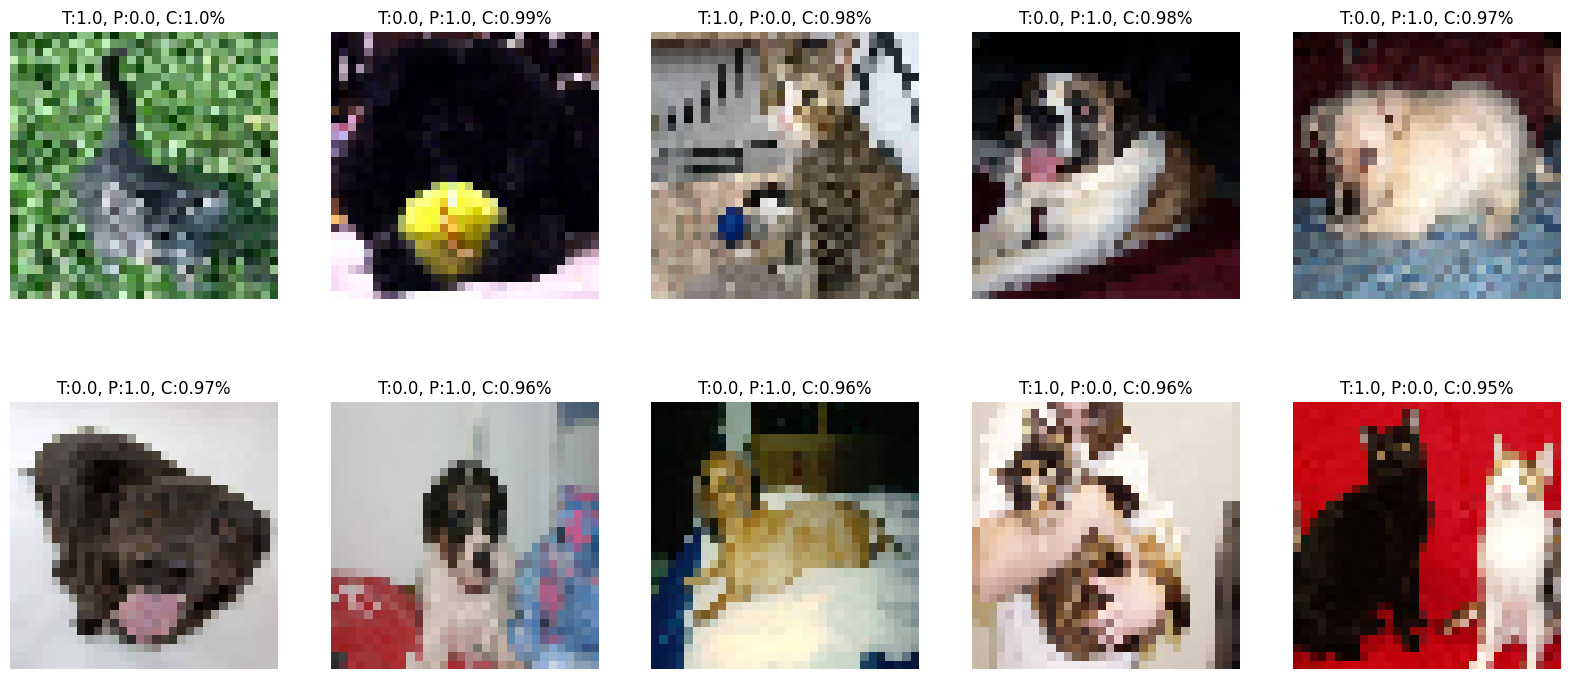

In [49]:
show_images_batch(X_test[errores.iloc[0:10].index],names= [f"T:{val1}, P:{val2}, C:{round(val3,2)}%" for val1,val2,val3 in errores.iloc[0:10].values], size_scale= 4)

In [50]:
X_train,y_train = read_data(TRAIN_PATH, (64,64))
X_test, y_test = read_data(TEST_PATH, (64,64))

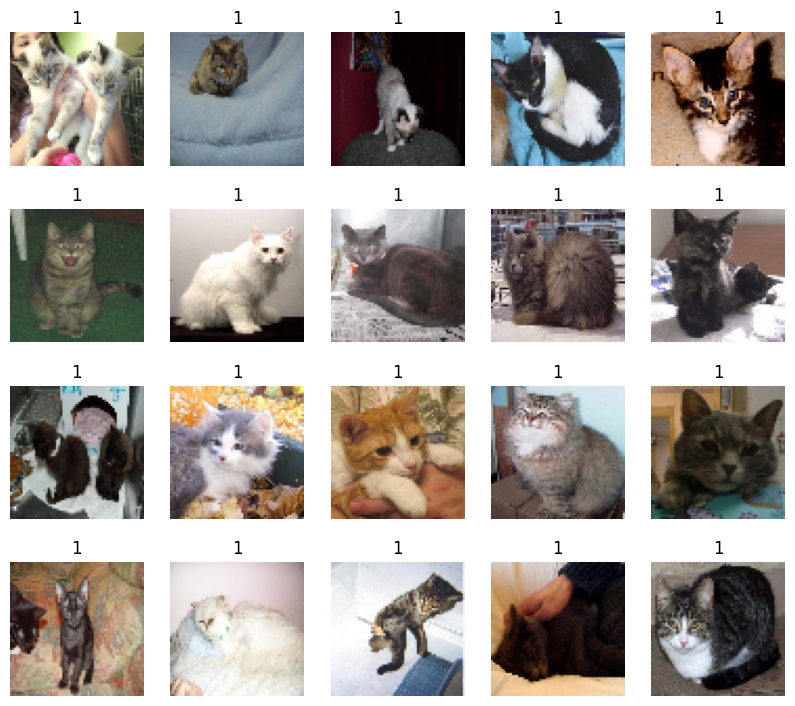

In [51]:
indices = np.random.randint(0,len(X_train),20)
show_images_batch(X_train[indices], names = y_train[indices], n_cols = 5)

In [52]:
y_train_num = np.array([mapa[y] for y in y_train])
y_test_num = np.array([mapa[y] for y in y_test])

In [53]:
X_train, y_train_num = shuffle(X_train, y_train_num)

In [54]:

capas = [keras.layers.Conv2D(filters = 32, kernel_size = (3, 3),
                            input_shape = (X_train[0].shape), 
                            padding = "same",
                            activation = 'relu'),
         keras.layers.MaxPooling2D(pool_size = (2, 2)),

# Añadimos otra capa de convolución y pooling
         keras.layers.Conv2D(filters = 16, 
                             kernel_size = (3, 3),
                             padding = "same", 
                             activation = 'relu'),
         keras.layers.MaxPooling2D(pool_size = (2, 2)),

# Añadimos una capa de flatten para convertir la salida de la capa de pooling en un vector
         keras.layers.Flatten(),

# Añadimos dos capas densas para la clasificación 
         keras.layers.Dense(units = 300, activation = 'relu'),
         keras.layers.Dense(units = 100, activation = 'relu'),

# Añadimos la capa de salida con 6 neuronas, una por cada clase
         keras.layers.Dense(6, activation = 'softmax')]

# Creamos el modelo
model = keras.Sequential(capas)

In [55]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')

In [56]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 16, 16, 16)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 4096)              0         
                                                                 
 dense_6 (Dense)             (None, 300)              

In [57]:
history = model.fit(X_train,
                    y_train_num,
                    validation_split = 0.2,
                    epochs = 100,
                    batch_size = 64, callbacks= [keras.callbacks.EarlyStopping(patience = 10, restore_best_weights= True)])

Epoch 1/100
13/13 [==============================] - 2s 77ms/step - loss: 2.3428 - accuracy: 0.9212 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/100
13/13 [==============================] - 1s 55ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/100
13/13 [==============================] - 1s 54ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/100
13/13 [==============================] - 1s 55ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/100
13/13 [==============================] - 1s 52ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/100
13/13 [==============================] - 1s 55ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/100
13/13 [==============================] - 1s 57ms/step - loss: 0.0000e+00 - accuracy: 1.0000 

In [58]:
model.evaluate(X_test, y_test_num)

32/32 [==============================] - 0s 10ms/step - loss: 1987.3680 - accuracy: 0.5000


[1987.3680419921875, 0.5]

In [59]:
y_pred = [ np.argmax(prediction) for prediction in model.predict(X_test)]

32/32 [==============================] - 0s 9ms/step


In [60]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
inverse_map = {valor:clave for clave,valor in mapa.items()}
y_test_labels = [inverse_map[y] for y in y_test_num]
y_pred_labels = [inverse_map[y] for y in y_pred]
print(classification_report(y_test_labels, y_pred_labels))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       500
           1       0.50      1.00      0.67       500

    accuracy                           0.50      1000
   macro avg       0.25      0.50      0.33      1000
weighted avg       0.25      0.50      0.33      1000



c:\Users\adrif\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\adrif\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\adrif\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [61]:
confianza = [prediction.max() for prediction in model.predict(X_test)]
pred_df = pd.DataFrame({"True": y_test_labels, "Predicted": y_pred_labels, "Confianza": confianza})

32/32 [==============================] - 0s 9ms/step


In [62]:
error = pred_df["True"] != pred_df["Predicted"]
errores = pred_df[error].sort_values("Confianza", ascending = False)
errores

,True,Predicted,Confianza
500,0,1,1.0
829,0,1,1.0
842,0,1,1.0
841,0,1,1.0
840,0,1,1.0
...,...,...,...
661,0,1,1.0
660,0,1,1.0
659,0,1,1.0
658,0,1,1.0


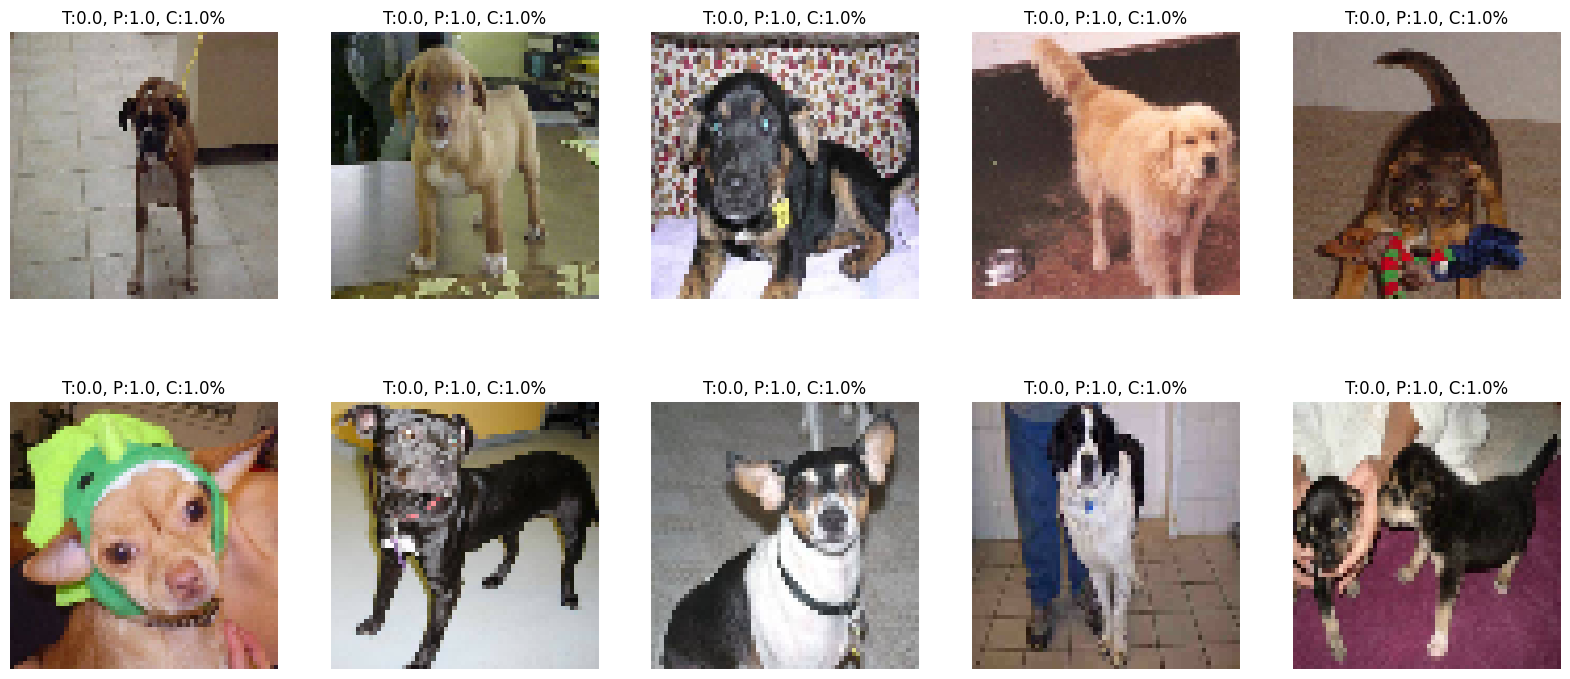

In [63]:
show_images_batch(X_test[errores.iloc[0:10].index],names= [f"T:{val1}, P:{val2}, C:{round(val3,2)}%" for val1,val2,val3 in errores.iloc[0:10].values], size_scale= 4)